# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [64]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

In [3]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, node1 in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            yield node1, nodes[j % n]

In [4]:
def make_ring_lattice(n, k):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

In [5]:
lattice = make_ring_lattice(10, 4)

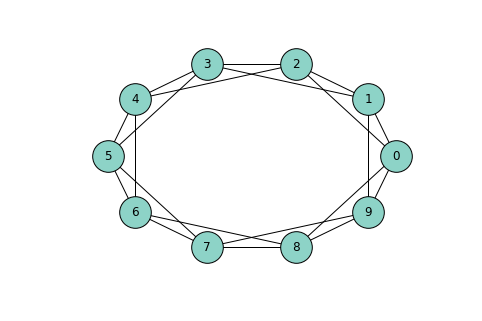

In [6]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

## WS graph

In [7]:
from numpy.random import random
from numpy.random import choice

def flip(p):
    return random() < p

In [8]:
def rewire(G, p):
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            new_v = choice(tuple(nodes - {u, v}))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            

In [9]:
def make_ws_graph(n, k, p):
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

In [10]:
ws = make_ws_graph(10, 4, 0.2)

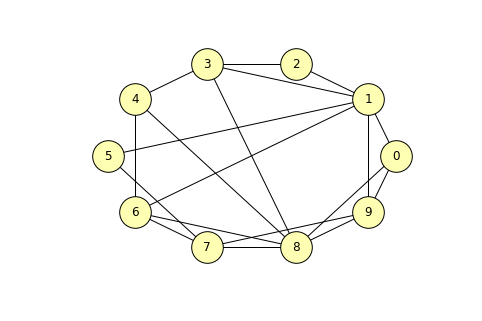

In [11]:
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

## Clustering

In [12]:
def node_clustering(G, node):
    neighbors = G.neighbors(node)
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    num = 0
    den = k * (k-1) / 2
    
    for i, u in enumerate(neighbors):
        for j, v in enumerate(neighbors):
            if i<j and G.has_edge(u, v):
                num +=1
    return num / den

In [13]:
node_clustering(ws, 1)

0.13333333333333333

In [14]:
def clustering_coefficient(G):
    cc = np.mean([node_clustering(G, node) 
                  for node in G.nodes()])
    return cc

In [15]:
clustering_coefficient(ws)

0.43000000000000005

## Path length

In [16]:
def all_pairs(nodes):
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if i < j:
                yield node1, node2

In [42]:
def path_lengths(G):
    nodes = G.nodes()
    paths = nx.shortest_path(G)
    path_lengths = [len(paths[u][v]) 
                    for u, v in all_pairs(nodes)]
    return path_lengths

In [43]:
def mean_path_length(G):
    return np.mean(path_lengths(G))

In [44]:
mean_path_length(ws)

2.6222222222222222

## The experiment

In [80]:
ps = np.logspace(-4, 0, 9)
ps

array([  1.00000000e-04,   3.16227766e-04,   1.00000000e-03,
         3.16227766e-03,   1.00000000e-02,   3.16227766e-02,
         1.00000000e-01,   3.16227766e-01,   1.00000000e+00])

In [81]:
def run_one_graph(n, k, p):
    ws = make_ws_graph(n, k, p)    
    mpl = mean_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

In [82]:
%time run_one_graph(1000, 10, 0.01)

11.1675535536 0.652813636364
CPU times: user 2.37 s, sys: 120 ms, total: 2.49 s
Wall time: 2.39 s


(11.167553553553553, 0.65281363636363632)

In [83]:
def run_experiment(ps, n=1000, k=10, iters=3):
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

In [84]:
res = run_experiment(ps)

0.0001
51.4504504505 0.666666666667
40.4252012012 0.666206565657
51.4504504505 0.666666666667
0.000316227766017
39.7512772773 0.666107575758
39.5084404404 0.666278787879
35.7186086086 0.665818686869
0.001
21.2814234234 0.66277020202
25.6853873874 0.664655050505
26.1880960961 0.664970707071
0.00316227766017
16.8487227227 0.661147474747
16.4343263263 0.662671212121
19.2691231231 0.663386868687
0.01
11.248952953 0.652049278499
9.6092992993 0.646685786436
10.0481641642 0.647307575758
0.0316227766017
6.74273473473 0.597565456765
6.98556556557 0.609318831169
7.23924124124 0.616686796537
0.1
5.46676876877 0.494612443112
5.44884084084 0.494308319458
5.46713313313 0.497038877789
0.316227766017
4.5785965966 0.217962728938
4.58253453453 0.21893490121
4.58802002002 0.221740767566
1.0
4.27668268268 0.0091279965992
4.27517117117 0.00925640132142
4.27707507508 0.00998273136392


In [87]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
L = np.array(L) / L[0]
C = np.array(C) / C[0]

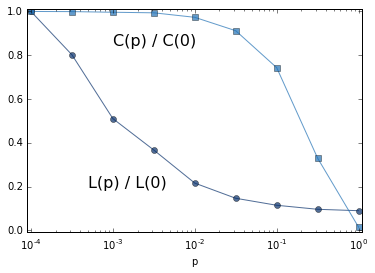

In [104]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

## Breadth-first search

In [107]:
lattice = make_ring_lattice(10, 4)

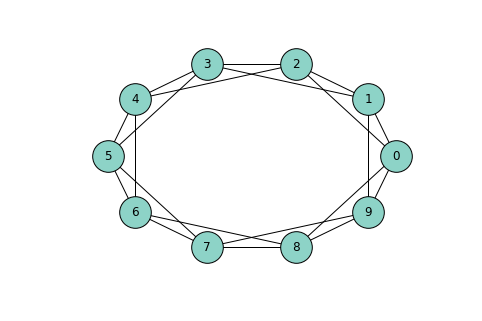

In [108]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

In [110]:
lattice.neighbors(2)

[0, 1, 3, 4]

In [198]:
from collections import deque

def reachable_nodes_bfs(G, start):
    reachable = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in reachable:
            reachable.add(node)
            neighbors = set(G[node]) 
            neighbors -= reachable
            queue.extend(neighbors)
    return reachable

In [199]:
len(reachable_nodes_bfs(lattice, 0))

1000

## Dijkstra's algorithm

## Exercises

In [200]:
def _plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

In [201]:
lattice = make_ring_lattice(1000, 10)

In [202]:
%timeit len(reachable_nodes_bfs(lattice, 0))

100 loops, best of 3: 5.52 ms per loop


In [203]:
%timeit len(_plain_bfs(lattice, 0))

1000 loops, best of 3: 758 µs per loop


In [131]:
def chains(n):
    iterator = iter([-1])
    for i in range(n):
        iterator = chain(iterator, [i])
        
    for i in iterator:
        i

In [141]:
%time chains(80000)

CPU times: user 46.5 s, sys: 12 ms, total: 46.6 s
Wall time: 46.5 s


## Regular graphs

In [23]:
def adjacent_edges(nodes, k):
    n = len(nodes)
    for i, node1 in enumerate(nodes):
        for j in range(i+1, i+k+1):
            yield node1, nodes[j % n]

In [24]:
def opposite_edges(nodes):
    n = len(nodes)
    assert n%2 == 0

    for i, node1 in enumerate(nodes):
        j = i + n//2
        yield node1, nodes[j % n]

In [25]:
def make_regular_graph(n, k):
    a, b = divmod(k, 2)
    
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))
    
    if b:
        G.add_edges_from(opposite_edges(nodes))
    return G

In [26]:
regular = make_regular_graph(10, 4)

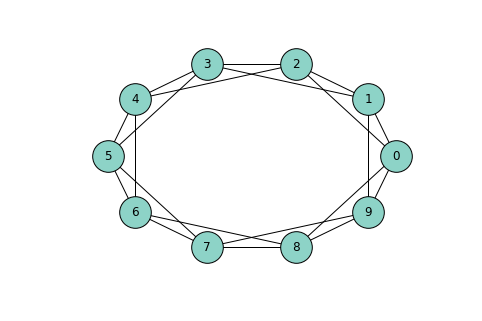

In [27]:
nx.draw_circular(regular, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)